In [1]:
# Change directory to the upper directory.
import os

analysis_dir_name = "analysis"

current_dir = os.path.split(os.getcwd())[1]
if current_dir == analysis_dir_name:
    os.chdir("..")

In [2]:
import ai.nn.data_set as ds
from ai.nn.neural_network import create_model_1, format_data_set, get_inputs_real_outputs
from ai.nn.evaluation import pivot_value, confusion_matrix, accuracy_recall_specificity, errors
from ai.helpers import data_set_file_path

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
seed = 42
min_ratio = 0.25
max_ratio = 0.75
step = 0.05

subgrid_radius = 2
num_tiles_subgrids = ((subgrid_radius * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
max_num_subgrids = 10000
# 'bm' means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10

ds_no_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, False)
ds_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, True)
# 'bm' means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

ratio_list = [round(ratio, 3) for ratio in np.arange(min_ratio, (max_ratio + step), step)]
err_list = []
for ratio in ratio_list:
    print("Ratio: {}".format(ratio))
    
    num_no_bm_subgrids = int(max_num_subgrids * (1 - ratio))
    num_bm_subgrids = int(max_num_subgrids * ratio)
    # So, 'num_bm_subgrids' / ('num_no_bm_subgrids' + 'num_bm_subgrids') = 'ratio'.
    
    # Load the data set.
    data_set_gen = ds.read_data_set(ds_no_bm_file_name)
    data_set = [next(data_set_gen) for i in range(num_no_bm_subgrids)]
    
    data_set_gen = ds.read_data_set(ds_bm_file_name)
    data_set.extend([next(data_set_gen) for i in range(num_bm_subgrids)])
    
     # Format the data set.
    data_set = format_data_set(data_set, num_masked_subgrids)
    
    # Get the 'x' and 'y_true' vectors.
    x, y_true = get_inputs_real_outputs(data_set)

    # Create the model.
    model = create_model_1(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x, y_true, epochs=1, batch_size=10)
    
    # Prediction and errors.
    y_pred = model.predict(x)
    y_pred = [y_p[0] for y_p in y_pred]
    
    # Confusion matrix.
    pivot = pivot_value(y_pred, (1 - ratio))
    conf_mat = confusion_matrix(y_true, y_pred, pivot)
    conf_mat_names = ["True negatives", "False positives", "False negatives", "True positives"]
    accuracy, recall, specificity = accuracy_recall_specificity(conf_mat)
    
    print("Confusion matrix, accuracy, recall and specificity:")
    print("\tPivot: {}".format(pivot))
    for cf_name, cf_tile in zip(conf_mat_names, conf_mat):
        print("\t{}: {}".format(cf_name, cf_tile))
    print("\tAccuracy: {}\n\tRecall: {}\n\tSpecificity: {}".format(accuracy, recall, specificity))

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true, y_pred, error_func)

    err_list.append(err)
    
    print('')
    

Ratio: 0.25
Epoch 1/1
100000/100000 [==============================] - 14s 141us/step - loss: 0.1294 - mean_squared_error: 0.1294 - mean_absolute_error: 0.2467 - acc: 0.8241
Confusion matrix, accuracy, recall and specificity:
	Pivot: 0.4191890135407448
	True negatives: 67482
	False positives: 7518
	False negatives: 7518
	True positives: 17482
	Accuracy: 0.84964
	Recall: 0.69928
	Specificity: 0.89976

Ratio: 0.3
Epoch 1/1
100000/100000 [==============================] - 15s 151us/step - loss: 0.1358 - mean_squared_error: 0.1358 - mean_absolute_error: 0.2623 - acc: 0.8091
Confusion matrix, accuracy, recall and specificity:
	Pivot: 0.4457976669073105
	True negatives: 62648
	False positives: 7352
	False negatives: 7352
	True positives: 22648
	Accuracy: 0.85296
	Recall: 0.7549333333333333
	Specificity: 0.8949714285714285

Ratio: 0.35
Epoch 1/1
100000/100000 [==============================] - 15s 147us/step - loss: 0.1423 - mean_squared_error: 0.1423 - mean_absolute_error: 0.2757 - acc: 0.79

In [29]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
median_color = 'red'
dot_color = 'black'

save_fig = True
plot_path = analysis_dir_name + "/plots/"
fig_format = 'png'
fig_dpi = 500

In [30]:
ratios = []
errs = []
for ratio, err in zip(ratio_list, err_list):
    ratios.extend([ratio] * len(err))
    errs.extend(err)

#random.seed(42)

# Add a jitter.
jitter = step / 2
ratios = [(ratio + random.uniform(-jitter, jitter)) for ratio in ratios]

"""
# Add a second jitter.
jitter /= 2
ratios = [(ratio + random.uniform(-jitter, jitter)) for ratio in ratios]
"""

'\n# Add a second jitter.\njitter /= 2\nratios = [(ratio + random.uniform(-jitter, jitter)) for ratio in ratios]\n'

<IPython.core.display.Javascript object>


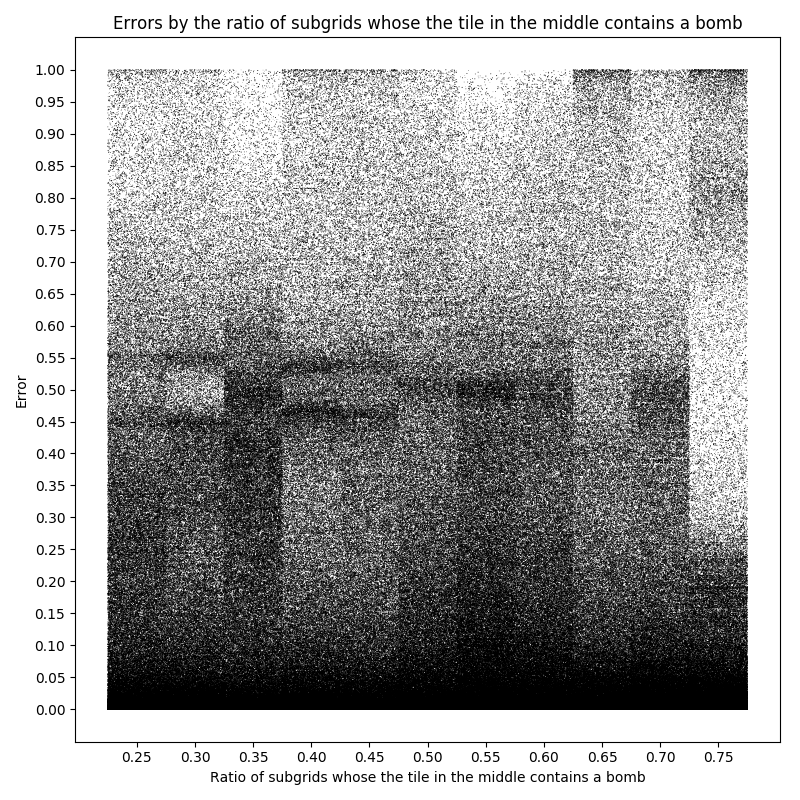

In [31]:
# Scatter plot of errors by the ratio of subgrids whose the tile in the middle contains a bomb.

fig = plt.figure(figsize=(8, 8))
plt.scatter(ratios, errs, s=np.arange(0.1, 0.6, 0.1), linewidths=0.01, c=dot_color)

plt.xticks(ratio_list)
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the ratio of subgrids whose the tile in the middle contains a bomb')
plt.xlabel('Ratio of subgrids whose the tile in the middle contains a bomb')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_by_bm_subgrids_ratio.' + fig_format), format=fig_format, dpi=fig_dpi)